In [15]:
# Import required libraries
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import findspark
from pyspark import SparkFiles
from pyspark.sql import SparkSession
from mrjob.job import MRJob
import geopandas as gpd
from pprint import pprint
import warnings
import seaborn as sns
import mplcursors
import dash
import re
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
from shapely.geometry import Point, LineString
import folium
from folium.plugins import MarkerCluster
import json
warnings.filterwarnings('ignore')

In [3]:
# Specify file path
zip_file_path = 'C:/Users/mmack/OneDrive/Desktop/temp_holding_folder/archive.zip'
csv_file_name = 'US_Accidents_March23.csv'

In [4]:
# Extract the CSV file from the zip archive (large file size prevents loading file directly)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extract(csv_file_name)

In [5]:
# Read the CSV file using Pandas and filter for rows where 'state' = 'CA'
df = pd.read_csv(csv_file_name, 
                 usecols=[0, 2, 4, 7, 8, 10, 11, 12, 13, 14, 15, 20, 21, 22, 23, 24, 26, 27, 28, 42])

# Convert column names to lowercase
df.columns = df.columns.str.lower()

# Filter for rows where 'state' = 'ca'
df = df[df['state'] == 'CA']

# Convert the 'end_time' column to datetime
df['end_time'] = pd.to_datetime(df['end_time'], errors='coerce')

# Filter the DataFrame for rows where 'end_time' is in the year 2022
df_2022 = df[df['end_time'].dt.year == 2022]

# Display the first few rows of the filtered DataFrame
print(df_2022.head())

              id  severity            end_time  end_lat  end_lng  \
512218  A-512231         1 2022-09-08 04:31:32      NaN      NaN   
512243  A-512257         1 2022-09-08 02:32:20      NaN      NaN   
512262  A-512277         3 2022-09-07 22:38:20      NaN      NaN   
512314  A-512340         2 2022-09-08 02:33:13      NaN      NaN   
512315  A-512341         1 2022-09-08 03:00:27      NaN      NaN   

                                              description           street  \
512218        Crash on CA-138 Pearblossom Hwy at 96th St.  Pearblossom Hwy   
512243  Crash on US-101 Southbound before Exit 44 Moor...           US-101   
512262  #1 lane blocked due to crash on I-5 Northbound...              I-5   
512314  HOV lane blocked due to crash on CA-57 Southbo...            CA-57   
512315                   Crash on Valley View Ave at I-5.   Firestone Blvd   

                    city       county state zipcode  temperature(f)  \
512218        Littlerock  Los Angeles    CA   93543

In [6]:
# Display basic information of the DataFrame
display(df_2022.info())

<class 'pandas.core.frame.DataFrame'>
Index: 266128 entries, 512218 to 5421631
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   id                 266128 non-null  object        
 1   severity           266128 non-null  int64         
 2   end_time           266128 non-null  datetime64[ns]
 3   end_lat            229151 non-null  float64       
 4   end_lng            229151 non-null  float64       
 5   description        266128 non-null  object        
 6   street             264969 non-null  object        
 7   city               266127 non-null  object        
 8   county             266128 non-null  object        
 9   state              266128 non-null  object        
 10  zipcode            266065 non-null  object        
 11  temperature(f)     259396 non-null  float64       
 12  wind_chill(f)      256768 non-null  float64       
 13  humidity(%)        259107 non-null  float64

None

In [7]:
# Drop rows with missing values in specific columns
df_2022_cleaned = df_2022.dropna(subset=['end_time', 'end_lat', 'end_lng', 'description', 'street', 'city', 'zipcode', 'temperature(f)', 'visibility(mi)', 'wind_speed(mph)', 'weather_condition', 'sunrise_sunset'])
df_2022_cleaned.head()

,id,severity,end_time,end_lat,end_lng,description,street,city,county,state,zipcode,temperature(f),wind_chill(f),humidity(%),pressure(in),visibility(mi),wind_speed(mph),precipitation(in),weather_condition,sunrise_sunset
3677754,A-3705263,2,2022-05-14 12:47:56,34.703485,-120.469720,Incident on MESA CIRCLE DR near HOUSE 3947 Dri...,Mesa Circle Dr,Lompoc,Santa Barbara,CA,93436-1480,70.0,70.0,53.0,29.89,10.0,15.0,0.0,Fair,Day
3677755,A-3705264,2,2022-11-09 08:06:30,33.141815,-117.187222,Slow traffic on CA-78 W from Twin Oaks Valley ...,CA-78 W,San Marcos,San Diego,CA,92069,57.0,57.0,69.0,29.71,10.0,0.0,0.0,Partly Cloudy,Day
3677758,A-3705267,2,2022-09-20 10:08:34,37.250788,-121.906476,Incident on CA-85 NB near CAMDEN AVE Right lan...,Meridian Ave,San Jose,Santa Clara,CA,95118,63.0,63.0,72.0,29.77,10.0,0.0,NaN,Partly Cloudy,Day
3677759,A-3705268,2,2022-04-16 00:34:49,37.250786,-121.906474,Incident on CA-85 NB near CAMDEN AVE Expect de...,CA-85,San Jose,Santa Clara,CA,95118,55.0,55.0,58.0,29.84,10.0,0.0,NaN,Partly Cloudy,Night
3677760,A-3705269,2,2022-12-29 11:04:30,36.548376,-121.909967,Stationary traffic on CA-1 from Camino Del Mon...,Highway 1,Carmel,Monterey,CA,93923,50.0,50.0,93.0,29.70,2.0,5.0,0.0,Light Rain,Day


In [8]:
# Select the 'county' and 'zipcode' columns
county_zipcode_list = df_2022_cleaned[['county', 'zipcode']]

# Truncate 'zipcode' to the first 5 characters
county_zipcode_list['zipcode'] = county_zipcode_list['zipcode'].str[:5]

# Drop duplicates to get unique combinations
county_zipcode_list = county_zipcode_list.drop_duplicates()

# Sort by 'county' and then by 'zipcode'
county_zipcode_list = county_zipcode_list.sort_values(by=['county', 'zipcode'])

# Convert to a list of tuples
county_zipcode_list = list(county_zipcode_list.itertuples(index=False, name=None))

# Display the list of unique combinations
county_zipcode_list

[('Alameda', '94501'),
 ('Alameda', '94502'),
 ('Alameda', '94514'),
 ('Alameda', '94536'),
 ('Alameda', '94538'),
 ('Alameda', '94539'),
 ('Alameda', '94541'),
 ('Alameda', '94542'),
 ('Alameda', '94544'),
 ('Alameda', '94545'),
 ('Alameda', '94546'),
 ('Alameda', '94550'),
 ('Alameda', '94551'),
 ('Alameda', '94552'),
 ('Alameda', '94555'),
 ('Alameda', '94560'),
 ('Alameda', '94566'),
 ('Alameda', '94568'),
 ('Alameda', '94577'),
 ('Alameda', '94578'),
 ('Alameda', '94579'),
 ('Alameda', '94580'),
 ('Alameda', '94586'),
 ('Alameda', '94587'),
 ('Alameda', '94588'),
 ('Alameda', '94601'),
 ('Alameda', '94602'),
 ('Alameda', '94603'),
 ('Alameda', '94605'),
 ('Alameda', '94606'),
 ('Alameda', '94607'),
 ('Alameda', '94608'),
 ('Alameda', '94609'),
 ('Alameda', '94610'),
 ('Alameda', '94611'),
 ('Alameda', '94612'),
 ('Alameda', '94613'),
 ('Alameda', '94618'),
 ('Alameda', '94619'),
 ('Alameda', '94621'),
 ('Alameda', '94702'),
 ('Alameda', '94703'),
 ('Alameda', '94704'),
 ('Alameda'

In [9]:
# Lists of California counties population and drivers
california_counties_population = [
    ("Alameda", 1622188),
    ("Alpine", 1141),
    ("Amador", 41811),
    ("Butte", 207172),
    ("Calaveras", 46565),
    ("Colusa", 22037),
    ("Contra Costa", 1155025),
    ("Del Norte", 26589),
    ("El Dorado", 192215),
    ("Fresno", 1017162),
    ("Glenn", 28129),
    ("Humboldt", 133985),
    ("Imperial", 179057),
    ("Inyo", 18527),
    ("Kern", 913820),
    ("Kings", 152682),
    ("Lake", 67878),
    ("Lassen", 28861),
    ("Los Angeles", 9663345),
    ("Madera", 162858),
    ("Marin", 254407),
    ("Mariposa", 16919),
    ("Mendocino", 89108),
    ("Merced", 291920),
    ("Modoc", 8500),
    ("Mono", 13066),
    ("Monterey", 430723),
    ("Napa", 133216),
    ("Nevada", 102037),
    ("Orange", 3135755),
    ("Placer", 423561),
    ("Plumas", 19131),
    ("Riverside", 2492442),
    ("Sacramento", 1584288),
    ("San Benito", 68175),
    ("San Bernardino", 2195611),
    ("San Diego", 3269973),
    ("San Francisco", 808988),
    ("San Joaquin", 800965),
    ("San Luis Obispo", 281639),
    ("San Mateo", 726353),
    ("Santa Barbara", 441257),
    ("Santa Clara", 1877592),
    ("Santa Cruz", 261547),
    ("Shasta", 180366),
    ("Sierra", 3200),
    ("Siskiyou", 42905),
    ("Solano", 449218),
    ("Sonoma", 481812),
    ("Stanislaus", 551430),
    ("Sutter", 97948),
    ("Tehama", 64896),
    ("Trinity", 15670),
    ("Tulare", 479468),
    ("Tuolumne", 54204),
    ("Ventura", 829590),
    ("Yolo", 220544),
    ("Yuba", 85722)
]

california_counties_drivers = [
    ("Alameda", 1133248),
    ("Alpine", 1152),
    ("Amador", 29584),
    ("Butte", 150472),
    ("Calaveras", 37529),
    ("Colusa", 15061),
    ("Contra Costa", 824776),
    ("Del Norte", 17781),
    ("El Dorado", 152474),
    ("Fresno", 600899),
    ("Glenn", 20461),
    ("Humboldt", 96258),
    ("Imperial", 122431),
    ("Inyo", 14245),
    ("Kern", 531874),
    ("Kings", 79811),
    ("Lake", 46901),
    ("Lassen", 18328),
    ("Los Angeles", 6581750),
    ("Madera", 91756),
    ("Marin", 194988),
    ("Mariposa", 13891),
    ("Mendocino", 65529),
    ("Merced", 163059),
    ("Modoc", 6633),
    ("Mono", 9403),
    ("Monterey", 274211),
    ("Napa", 100786),
    ("Nevada", 83294),
    ("Orange", 2308918),
    ("Placer", 306269),
    ("Plumas", 16201),
    ("Riverside", 1615036),
    ("Sacramento", 1059829),
    ("San Benito", 44703),
    ("San Bernardino", 1425931),
    ("San Diego", 2361084),
    ("San Francisco", 574119),
    ("San Joaquin", 491088),
    ("San Luis Obispo", 203180),
    ("San Mateo", 547328),
    ("Santa Barbara", 292196),
    ("Santa Clara", 1378403),
    ("Santa Cruz", 189420),
    ("Shasta", 133577),
    ("Sierra", 2326),
    ("Siskiyou", 34487),
    ("Solano", 312480),
    ("Sonoma", 361821),
    ("Stanislaus", 355857),
    ("Sutter", 67863),
    ("Tehama", 44151),
    ("Trinity", 9158),
    ("Tulare", 272095),
    ("Tuolumne", 41007),
    ("Ventura", 611327),
    ("Yolo", 139613),
    ("Yuba", 50733)
]

# Convert lists to DataFrames
df_population = pd.DataFrame(california_counties_population, columns=['county', 'population'])
df_drivers = pd.DataFrame(california_counties_drivers, columns=['county', 'licensed_drivers'])

# Merge DataFrames on 'county'
ca_county_data_df = pd.merge(df_population, df_drivers, on='county')

# Display the merged DataFrame
ca_county_data_df.head()

,county,population,licensed_drivers
0,Alameda,1622188,1133248
1,Alpine,1141,1152
2,Amador,41811,29584
3,Butte,207172,150472
4,Calaveras,46565,37529


In [10]:
display(ca_county_data_df.info())
display(df_2022_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   county            58 non-null     object
 1   population        58 non-null     int64 
 2   licensed_drivers  58 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.5+ KB


None

<class 'pandas.core.frame.DataFrame'>
Index: 218591 entries, 3677754 to 5421631
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   id                 218591 non-null  object        
 1   severity           218591 non-null  int64         
 2   end_time           218591 non-null  datetime64[ns]
 3   end_lat            218591 non-null  float64       
 4   end_lng            218591 non-null  float64       
 5   description        218591 non-null  object        
 6   street             218591 non-null  object        
 7   city               218591 non-null  object        
 8   county             218591 non-null  object        
 9   state              218591 non-null  object        
 10  zipcode            218591 non-null  object        
 11  temperature(f)     218591 non-null  float64       
 12  wind_chill(f)      218591 non-null  float64       
 13  humidity(%)        218359 non-null  float6

None

In [11]:
# Merge df_2022_cleaned with ca_county_data_df on 'county'
merged_df = df_2022_cleaned.merge(ca_county_data_df, on='county', how='left')

# Calculate the number of accidents per county
accident_counts = merged_df.groupby('county').size().reset_index(name='accident_count')

# Merge the accident counts back into the merged DataFrame
result_df = merged_df.merge(accident_counts, on='county', how='left')

# Add calculated columns

# Accidents per 100,000 licensed drivers
result_df['accidents_per_100k_drivers'] = (result_df['accident_count'] / result_df['licensed_drivers']) * 100000

# Accidents per 100,000 population
result_df['accidents_per_100k_population'] = (result_df['accident_count'] / result_df['population']) * 100000

# Percentage of licensed drivers involved in accidents
result_df['percent_drivers_involved'] = (result_df['accident_count'] / result_df['licensed_drivers']) * 100

# Display the updated DataFrame
result_df.head()

,id,severity,end_time,end_lat,end_lng,description,street,city,county,state,...,wind_speed(mph),precipitation(in),weather_condition,sunrise_sunset,population,licensed_drivers,accident_count,accidents_per_100k_drivers,accidents_per_100k_population,percent_drivers_involved
0,A-3705263,2,2022-05-14 12:47:56,34.703485,-120.469720,Incident on MESA CIRCLE DR near HOUSE 3947 Dri...,Mesa Circle Dr,Lompoc,Santa Barbara,CA,...,15.0,0.0,Fair,Day,441257,292196,2314,791.934181,524.410944,0.791934
1,A-3705264,2,2022-11-09 08:06:30,33.141815,-117.187222,Slow traffic on CA-78 W from Twin Oaks Valley ...,CA-78 W,San Marcos,San Diego,CA,...,0.0,0.0,Partly Cloudy,Day,3269973,2361084,13959,591.211494,426.884259,0.591211
2,A-3705267,2,2022-09-20 10:08:34,37.250788,-121.906476,Incident on CA-85 NB near CAMDEN AVE Right lan...,Meridian Ave,San Jose,Santa Clara,CA,...,0.0,NaN,Partly Cloudy,Day,1877592,1378403,6765,490.785351,360.301919,0.490785
3,A-3705268,2,2022-04-16 00:34:49,37.250786,-121.906474,Incident on CA-85 NB near CAMDEN AVE Expect de...,CA-85,San Jose,Santa Clara,CA,...,0.0,NaN,Partly Cloudy,Night,1877592,1378403,6765,490.785351,360.301919,0.490785
4,A-3705269,2,2022-12-29 11:04:30,36.548376,-121.909967,Stationary traffic on CA-1 from Camino Del Mon...,Highway 1,Carmel,Monterey,CA,...,5.0,0.0,Light Rain,Day,430723,274211,2855,1041.169027,662.838994,1.041169


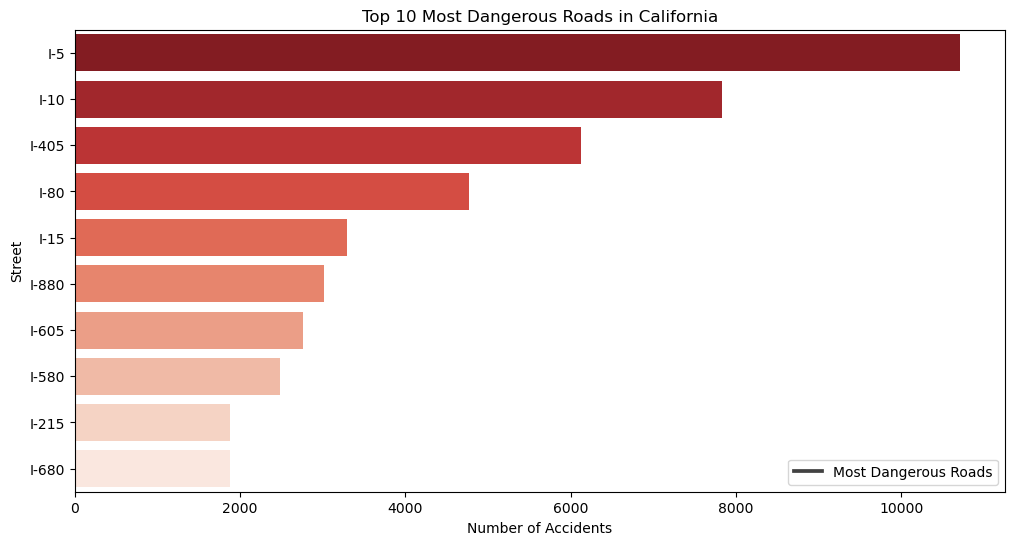

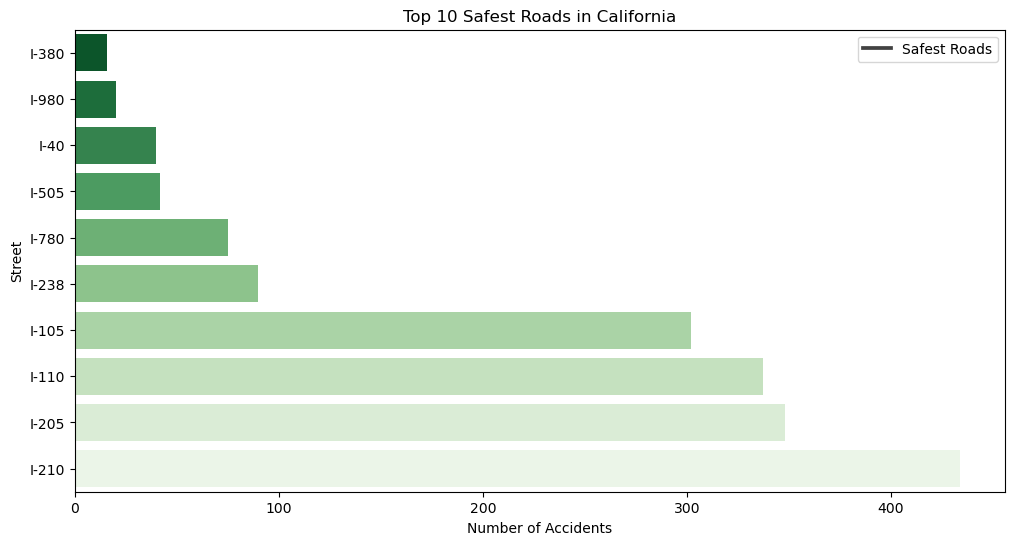

In [24]:
# Function to clean street names by removing extra text
def clean_street_name(street):
    match = re.match(r'(I-\d{1,3})', street)
    return match.group(1) if match else street

# Filter for state highways and interstate highways
highway_filter = result_df['street'].str.contains(r'\b(I-|CA)\d+', regex=True)
highway_accidents = result_df[highway_filter]

# Apply the function to clean street names
highway_accidents['clean_street'] = highway_accidents['street'].apply(clean_street_name)

# Group by 'clean_street' and calculate the total number of accidents
clean_street_accidents = highway_accidents.groupby('clean_street').size().reset_index(name='accident_count')

# Sort by 'accident_count' to find the most and least dangerous roads
most_dangerous_roads = clean_street_accidents.sort_values(by='accident_count', ascending=False).head(10)
safest_roads = clean_street_accidents.sort_values(by='accident_count', ascending=True).head(10)

# Plot the most dangerous roads
plt.figure(figsize=(12, 6))
sns.barplot(x='accident_count', y='clean_street', data=most_dangerous_roads, palette='Reds_r')
plt.title('Top 10 Most Dangerous Roads in California')
plt.xlabel('Number of Accidents')
plt.ylabel('Street')
plt.legend(['Most Dangerous Roads'])
plt.savefig('top_10_most_dangerous_roads.png')  # Save the plot as an image file
plt.show()

# Plot the safest roads
plt.figure(figsize=(12, 6))
sns.barplot(x='accident_count', y='clean_street', data=safest_roads, palette='Greens_r')
plt.title('Top 10 Safest Roads in California')
plt.xlabel('Number of Accidents')
plt.ylabel('Street')
plt.legend(['Safest Roads'])
plt.savefig('top_10_safest_roads.png')  # Save the plot as an image file
plt.show()

In [67]:
# # Function to clean street names by removing extra text
# def clean_street_name(street):
#     match = re.match(r'(I-\d{1,3})', street)
#     return match.group(1) if match else street

# # Filter for state highways and interstate highways
# highway_filter = result_df['street'].str.contains(r'\b(I-|CA)\d+', regex=True)
# highway_accidents = result_df[highway_filter]

# # Apply the function to clean street names
# highway_accidents['clean_street'] = highway_accidents['street'].apply(clean_street_name)

# # Merge 'highway_accidents' with 'result_df' to include the 'county' column
# highway_accidents = highway_accidents.merge(result_df[['street', 'county']], on='street', how='left')

# # Group by 'clean_street' and 'county' and calculate the total number of accidents
# clean_street_accidents = highway_accidents.groupby(['clean_street', 'county']).size().reset_index(name='accident_count')

# # Function to generate visualizations for a given county
# def visualize_roads_by_county(county_name):
#     # Filter the data for the specified county
#     county_data = clean_street_accidents[clean_street_accidents['county'] == county_name]
    
#     # Find the most dangerous road in the county
#     most_dangerous_road = county_data.loc[county_data['accident_count'].idxmax()]
    
#     # Find the safest road in the county
#     safest_road = county_data.loc[county_data['accident_count'].idxmin()]
    
#     # Plot the most dangerous road
#     plt.figure(figsize=(12, 6))
#     ax = sns.barplot(x='accident_count', y='clean_street', data=county_data[county_data['clean_street'] == most_dangerous_road['clean_street']], palette='Reds_r')
#     plt.title(f'Most Dangerous Road in {county_name}')
#     plt.xlabel('Number of Accidents')
#     plt.ylabel('Street')
#     cursor = mplcursors.cursor(ax, hover=True)
#     cursor.connect("add", lambda sel: sel.annotation.set_text(f'Accidents: {sel.target[0]:.0f}'))
#     plt.savefig(f'most_dangerous_road_{county_name}.png')
#     plt.show()
    
#     # Plot the safest road
#     plt.figure(figsize=(12, 6))
#     ax = sns.barplot(x='accident_count', y='clean_street', data=county_data[county_data['clean_street'] == safest_road['clean_street']], palette='Greens_r')
#     plt.title(f'Safest Road in {county_name}')
#     plt.xlabel('Number of Accidents')
#     plt.ylabel('Street')
#     cursor = mplcursors.cursor(ax, hover=True)
#     cursor.connect("add", lambda sel: sel.annotation.set_text(f'Accidents: {sel.target[0]:.0f}'))
#     plt.savefig(f'safest_road_{county_name}.png')
#     plt.show()

# # Prompt the user to enter a county name
# county_name = input("Enter the name of the county: ")

# # Generate the visualizations for the specified county
# visualize_roads_by_county(county_name)

In [ ]:
# # export top 10s for use in app

# # Convert the DataFrames to dictionaries
# most_dangerous_roads_dict = most_dangerous_roads.to_dict(orient='records')
# safest_roads_dict = safest_roads.to_dict(orient='records')

# # Convert Point objects to lists of coordinates
# for road in most_dangerous_roads_dict:
#     road['end_lat'] = road['end_lat'].y if hasattr(road['end_lat'], 'y') else road['end_lat']
#     road['end_lng'] = road['end_lng'].x if hasattr(road['end_lng'], 'x') else road['end_lng']

# for road in safest_roads_dict:
#     road['end_lat'] = road['end_lat'].y if hasattr(road['end_lat'], 'y') else road['end_lat']
#     road['end_lng'] = road['end_lng'].x if hasattr(road['end_lng'], 'x') else road['end_lng']

# # Save the dictionaries to JSON files
# with open('most_dangerous_roads.json', 'w') as f:
#     json.dump(most_dangerous_roads_dict, f)

# with open('safest_roads.json', 'w') as f:
#     json.dump(safest_roads_dict, f)

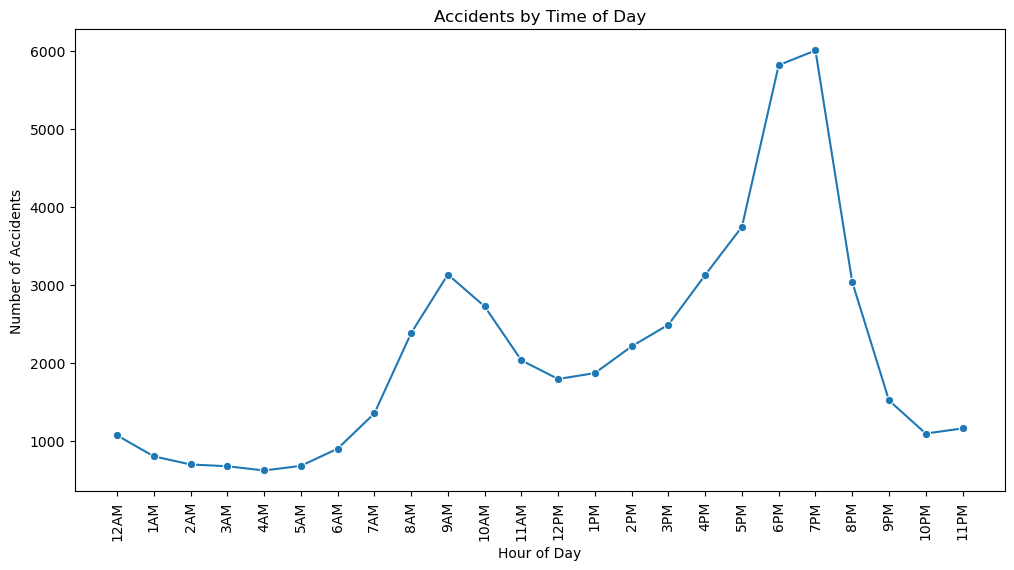

In [29]:
# Function to clean street names by removing extra text
def clean_street_name(street):
    match = re.match(r'(I-\d{1,3})', street)
    return match.group(1) if match else street

# Filter for state highways and interstate highways
highway_filter = result_df['street'].str.contains(r'\b(I-|CA)\d+', regex=True)
highway_accidents = result_df[highway_filter]

# Apply the function to clean street names
highway_accidents['clean_street'] = highway_accidents['street'].apply(clean_street_name)

# Group by 'clean_street' and calculate the total number of accidents
clean_street_accidents = highway_accidents.groupby('clean_street').size().reset_index(name='accident_count')

# Extract hour from end_time
highway_accidents['hour'] = highway_accidents['end_time'].dt.hour

# Group by hour and count accidents
accidents_by_hour = highway_accidents.groupby('hour').size().reset_index(name='accident_count')

# Convert hour to AM/PM format
hour_labels = {0: '12AM', 1: '1AM', 2: '2AM', 3: '3AM', 4: '4AM', 5: '5AM', 6: '6AM', 7: '7AM', 8: '8AM', 9: '9AM', 10: '10AM', 11: '11AM', 12: '12PM', 13: '1PM', 14: '2PM', 15: '3PM', 16: '4PM', 17: '5PM', 18: '6PM', 19: '7PM', 20: '8PM', 21: '9PM', 22: '10PM', 23: '11PM'}

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='hour', y='accident_count', data=accidents_by_hour, marker='o', palette='viridis')
plt.title('Accidents by Time of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Accidents')
plt.xticks(ticks=range(0, 24), labels=[hour_labels[hour] for hour in range(0, 24)], rotation=90)
plt.savefig('accidents_by_hour_line_chart.png')
plt.show()

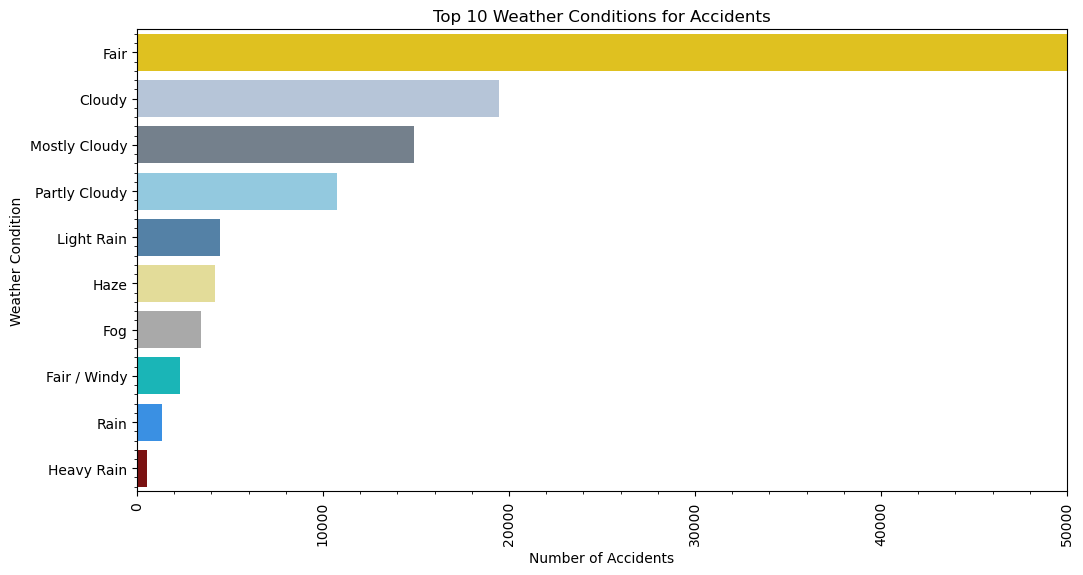

In [42]:
# Accidents by Weather Condition
# Group by weather_condition and count accidents
accidents_by_weather = result_df.groupby('weather_condition').size().reset_index(name='accident_count')

# Get top 10 weather conditions
top_10_weather = accidents_by_weather.nlargest(10, 'accident_count')

# Define a custom palette for the specified weather conditions
weather_palette = {
    'Fair': '#FFD700',          # Gold
    'Cloudy': '#B0C4DE',        # Light Steel Blue
    'Mostly Cloudy': '#708090', # Slate Gray
    'Partly Cloudy': '#87CEEB', # Sky Blue
    'Light Rain': '#4682B4',    # Steel Blue
    'Haze': '#F0E68C',          # Khaki
    'Fog': '#A9A9A9',           # Dark Gray
    'Fair / Windy': '#00CED1',  # Dark Turquoise
    'Rain': '#1E90FF',          # Dodger Blue
    'Heavy Rain': '#8B0000'     # Dark Red
}

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='accident_count', y='weather_condition', data=top_10_weather, palette=weather_palette)
plt.title('Top 10 Weather Conditions for Accidents')
plt.xlabel('Number of Accidents')
plt.ylabel('Weather Condition')
plt.xticks(rotation=90)
plt.xlim(0, 50000)  # Set x-axis limit
plt.minorticks_on()  # Enable minor ticks
plt.tick_params(axis='x', which='both', bottom=True, top=False)  # Customize tick parameters
plt.savefig('accidents_by_weather.png')
plt.show()

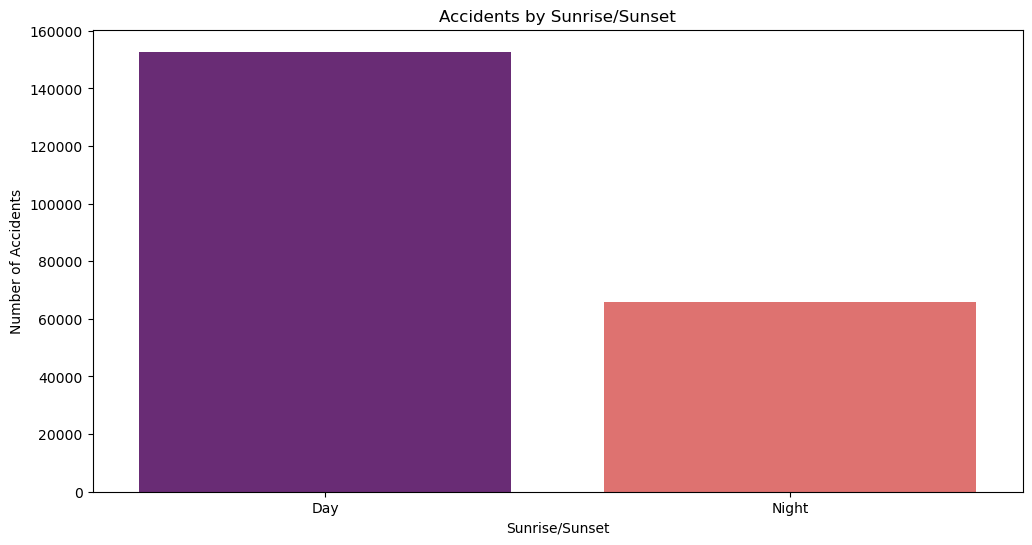

In [43]:
# Accidents by Sunrise/Sunset
# Group by sunrise_sunset and count accidents
accidents_by_sunrise_sunset = result_df.groupby('sunrise_sunset').size().reset_index(name='accident_count')

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='sunrise_sunset', y='accident_count', data=accidents_by_sunrise_sunset, palette='magma')
plt.title('Accidents by Sunrise/Sunset')
plt.xlabel('Sunrise/Sunset')
plt.ylabel('Number of Accidents')
plt.savefig('accidents_by_sunrise_sunset.png')
plt.show()

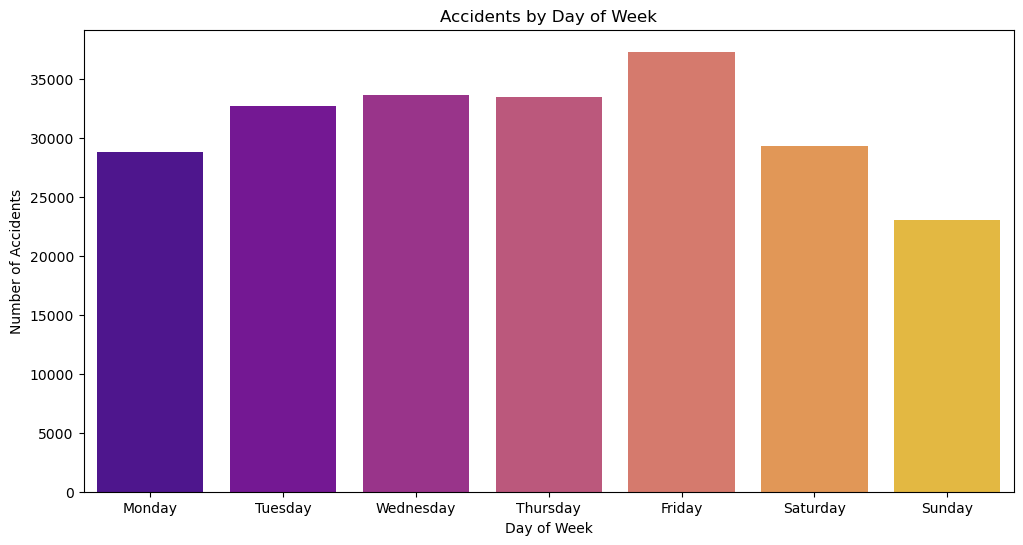

In [44]:
# Accidents by Day of Week
# Extract day of week from end_time
result_df['day_of_week'] = result_df['end_time'].dt.day_name()

# Group by day_of_week and count accidents
accidents_by_day = result_df.groupby('day_of_week').size().reset_index(name='accident_count')

# Order days of the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
accidents_by_day['day_of_week'] = pd.Categorical(accidents_by_day['day_of_week'], categories=days_order, ordered=True)
accidents_by_day = accidents_by_day.sort_values('day_of_week')

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='day_of_week', y='accident_count', data=accidents_by_day, palette='plasma')
plt.title('Accidents by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Accidents')
plt.savefig('accidents_by_day.png')
plt.show()

In [46]:
# # Accidents by Weekend/Weekday
# # Determine if the day is a weekend or weekday
# result_df['is_weekend'] = result_df['end_time'].dt.dayofweek >= 5

# # Group by is_weekend and count accidents
# accidents_by_weekend = result_df.groupby('is_weekend').size().reset_index(name='accident_count')
# accidents_by_weekend['is_weekend'] = accidents_by_weekend['is_weekend'].map({True: 'Weekend', False: 'Weekday'})

# # Plot
# plt.figure(figsize=(12, 6))
# sns.barplot(x='is_weekend', y='accident_count', data=accidents_by_weekend, palette='cividis')
# plt.title('Accidents by Weekend/Weekday')
# plt.xlabel('Weekend/Weekday')
# plt.ylabel('Number of Accidents')
# plt.savefig('accidents_by_weekend.png')
# plt.show()


In [48]:
fatal_df = pd.read_csv('c:/users/mmack/onedrive/desktop/fatal_accident_df.csv')
fatal_df.head()

,STATENAME,ST_CASE,PEDS,VE_TOTAL,COUNTYNAME,CITYNAME,MONTH,DAY,YEAR,HOUR,...,ARR_MIN,HOSP_HR,HOSP_MN,FATALS,ACCIDENT_DATE,NOT_TIME,AMBO_ARR_TIME,HOSP_ARR_TIME,TIME_TO_AMBO,TIME_TO_HOSP
0,California,60001,0,1,AMADOR (5),NOT APPLICABLE,1,2,2022,22,...,0,0,0,1,2022-01-02,2022-01-02 22:45:00,2022-01-02 23:00:00,2022-01-02 00:00:00,15.0,0.0
1,California,60002,0,2,SUTTER (101),NOT APPLICABLE,1,15,2022,7,...,0,0,0,1,2022-01-15,2022-01-15 00:00:00,2022-01-15 00:00:00,2022-01-15 00:00:00,0.0,0.0
2,California,60003,0,2,RIVERSIDE (65),NOT APPLICABLE,1,4,2022,15,...,0,0,0,1,2022-01-04,2022-01-04 00:00:00,2022-01-04 00:00:00,2022-01-04 00:00:00,0.0,0.0
3,California,60004,0,1,SAN DIEGO (73),NOT APPLICABLE,1,8,2022,11,...,0,0,0,1,2022-01-08,2022-01-08 00:00:00,2022-01-08 00:00:00,2022-01-08 00:00:00,0.0,0.0
4,California,60005,1,1,SACRAMENTO (67),NOT APPLICABLE,1,13,2022,17,...,12,0,0,1,2022-01-13,2022-01-13 18:00:00,2022-01-13 18:12:00,2022-01-13 00:00:00,12.0,0.0


In [49]:
display(fatal_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4109 entries, 0 to 4108
Data columns (total 31 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   STATENAME      4109 non-null   object 
 1   ST_CASE        4109 non-null   int64  
 2   PEDS           4109 non-null   int64  
 3   VE_TOTAL       4109 non-null   int64  
 4   COUNTYNAME     4109 non-null   object 
 5   CITYNAME       4109 non-null   object 
 6   MONTH          4109 non-null   int64  
 7   DAY            4109 non-null   int64  
 8   YEAR           4109 non-null   int64  
 9   HOUR           4109 non-null   int64  
 10  MINUTE         4109 non-null   int64  
 11  TWAY_ID        4109 non-null   object 
 12  TWAY_ID2       1081 non-null   object 
 13  RUR_URBNAME    4109 non-null   object 
 14  LATITUDE       4109 non-null   float64
 15  LONGITUDE      4109 non-null   float64
 16  HARM_EVNAME    4109 non-null   object 
 17  WEATHERNAME    4109 non-null   object 
 18  NOT_HOUR

None

In [54]:
# Calculate total fatalities by COUNTYNAME
county_fatal_df = fatal_df.groupby('COUNTYNAME')['FATALS'].sum().reset_index()

# Remove any non-alphabetic characters from the 'COUNTYNAME' values
county_fatal_df['COUNTYNAME'] = county_fatal_df['COUNTYNAME'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

# Change 'countyname' values to first letter uppercase and the remaining letters lowercase
county_fatal_df['COUNTYNAME'] = county_fatal_df['COUNTYNAME'].str.title()

# Change column names to lowercase
county_fatal_df.columns = county_fatal_df.columns.str.lower()

# Display the new DataFrame
print(county_fatal_df)

          countyname  fatals
0           Alameda      102
1            Alpine        2
2            Amador        7
3             Butte       32
4         Calaveras       16
5            Colusa       12
6      Contra Costa       67
7         Del Norte        5
8         El Dorado       28
9            Fresno      198
10            Glenn        7
11         Humboldt       25
12         Imperial       40
13             Inyo       12
14             Kern      206
15            Kings       40
16             Lake       18
17           Lassen        7
18      Los Angeles      858
19           Madera       48
20            Marin       16
21         Mariposa        1
22        Mendocino       17
23           Merced       70
24            Modoc        3
25             Mono        4
26         Monterey       57
27             Napa       11
28           Nevada       18
29           Orange      230
30           Placer       38
31           Plumas        5
32        Riverside      343
33       Sacra

In [61]:
result_df

,id,severity,end_time,end_lat,end_lng,description,street,city,county,state,...,weather_condition,sunrise_sunset,population,licensed_drivers,accident_count,accidents_per_100k_drivers,accidents_per_100k_population,percent_drivers_involved,day_of_week,is_weekend
0,A-3705263,2,2022-05-14 12:47:56,34.703485,-120.469720,Incident on MESA CIRCLE DR near HOUSE 3947 Dri...,Mesa Circle Dr,Lompoc,Santa Barbara,CA,...,Fair,Day,441257,292196,2314,791.934181,524.410944,0.791934,Saturday,True
1,A-3705264,2,2022-11-09 08:06:30,33.141815,-117.187222,Slow traffic on CA-78 W from Twin Oaks Valley ...,CA-78 W,San Marcos,San Diego,CA,...,Partly Cloudy,Day,3269973,2361084,13959,591.211494,426.884259,0.591211,Wednesday,False
2,A-3705267,2,2022-09-20 10:08:34,37.250788,-121.906476,Incident on CA-85 NB near CAMDEN AVE Right lan...,Meridian Ave,San Jose,Santa Clara,CA,...,Partly Cloudy,Day,1877592,1378403,6765,490.785351,360.301919,0.490785,Tuesday,False
3,A-3705268,2,2022-04-16 00:34:49,37.250786,-121.906474,Incident on CA-85 NB near CAMDEN AVE Expect de...,CA-85,San Jose,Santa Clara,CA,...,Partly Cloudy,Night,1877592,1378403,6765,490.785351,360.301919,0.490785,Saturday,True
4,A-3705269,2,2022-12-29 11:04:30,36.548376,-121.909967,Stationary traffic on CA-1 from Camino Del Mon...,Highway 1,Carmel,Monterey,CA,...,Light Rain,Day,430723,274211,2855,1041.169027,662.838994,1.041169,Thursday,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218586,A-5462816,2,2022-01-08 13:59:20,39.236989,-121.035045,Accident on Dorsey Dr (CA-49) from Brunswick R...,CA-20,Grass Valley,Nevada,CA,...,Fair,Day,102037,83294,1438,1726.414868,1409.292708,1.726415,Saturday,True
218587,A-5462824,2,2022-10-12 19:25:30,34.038475,-118.274553,Slow traffic on I-10 W - Santa Monica Fwy W fr...,I-10 W,Los Angeles,Los Angeles,CA,...,Fair,Day,9663345,6581750,58201,884.278497,602.286268,0.884278,Wednesday,False
218588,A-5462831,2,2022-03-10 15:26:52,36.982841,-121.964335,Stationary traffic from exit [438] to State Hi...,Soquel Ave,Santa Cruz,Santa Cruz,CA,...,Fair,Day,261547,189420,2235,1179.917643,854.530926,1.179918,Thursday,False
218589,A-5462838,2,2022-12-01 20:39:50,34.279295,-118.502125,Incident on RINALDI ST near BALBOA BLVD Drive ...,Rinaldi St,Granada Hills,Los Angeles,CA,...,Cloudy,Night,9663345,6581750,58201,884.278497,602.286268,0.884278,Thursday,False


In [62]:
# Check the column names of both DataFrames
print(clean_street_accidents.columns)
print(county_fatal_df.columns)

# # Ensure the county names match between the DataFrames
# ca_county_data_df['county'] = ca_county_data_df['county'].str.title()
# county_fatal_df['countyname'] = county_fatal_df['countyname'].str.title()

# # Merge the DataFrames on 'county' and 'countyname'
# merged_df = ca_county_data_df.merge(county_fatal_df, left_on='county', right_on='countyname', how='left')

# # Drop the 'countyname' column from the merged DataFrame
# merged_df.drop(columns=['countyname'], inplace=True)

# # Display the merged DataFrame
# print(merged_df)

Index(['clean_street', 'accident_count'], dtype='object')
Index(['countyname', 'fatals'], dtype='object')
